### Importação de Bibliotecas

In [2]:

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score

from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor

import xgboost as xgb

from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller

import warnings
warnings.filterwarnings("ignore")

plt.style.use("seaborn-v0_8")



### Funções Auxiliares 

In [4]:
# Transforma a coluna "hora" em datetime.

def convert_datetime(df, col="hora"):
    df[col] = pd.to_datetime(df[col], errors="coerce")
    return df

In [5]:
# Criar sequências para LSTM

def create_sequences(data, seq_len=48):  # 48 = 12h se forem intervalos de 15min
    X, y = [], []
    for i in range(len(data) - seq_len):
        X.append(data[i:i+seq_len])
        y.append(data[i+seq_len])
    return np.array(X), np.array(y)


In [6]:
# Normalizar séries temporais

def normalize_series(series):
    scaler = MinMaxScaler()
    series_scaled = scaler.fit_transform(series.reshape(-1, 1)).flatten()
    return series_scaled, scaler


In [7]:
# Plot de série temporal por CPE

def plot_series(df, cpe, col="DadosDeConsumo"):
    data = df[df["CPE"] == cpe].sort_values("hora")
    plt.figure(figsize=(14, 4))
    plt.plot(data["hora"], data[col])
    plt.title(f"Série temporal para CPE {cpe} ({col})")
    plt.xlabel("Tempo")
    plt.ylabel(col)
    plt.grid(True)
    plt.show()


In [8]:
# Dividir em treino e teste (70/30)

def split_train_test(series, train_ratio=0.7):
    n_train = int(len(series) * train_ratio)
    train = series[:n_train]
    test = series[n_train:]
    return train, test


In [9]:
# Baseline (valor de 1 semana antes)

def baseline_week_behind(series, steps_back=96*7):
    preds = []
    for i in range(steps_back, len(series)):
        preds.append(series[i - steps_back])
    return np.array(preds)


In [10]:
# Métricas padrão

def evaluate_model(y_true, y_pred, name="Modelo"):
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)

    print(f"---- {name} ----")
    print(f"MSE :  {mse:.4f}")
    print(f"RMSE:  {rmse:.4f}")
    print(f"MAE :  {mae:.4f}")

    return {"mse": mse, "rmse": rmse, "mae": mae}


In [11]:
# Adfuller — testar estacionaridade (ARIMA)

def test_stationarity(series):
    result = adfuller(series.dropna())
    print("ADF Statistic:", result[0])
    print("p-value:", result[1])
    if result[1] < 0.05:
        print("A série é estacionária (reject H0)")
    else:
        print("A série NÃO é estacionária (fail to reject H0)")


# 1. Business Understanding

# 2. Data Understanding

In [14]:
df = pd.read_csv("consumo15m_11_2025.csv")

In [15]:
print("\n--- Dimensões do dataset ---")
print(df.shape)

print("\n--- Info() ---")
df.info()

print("\n--- Describe() ---")
df.describe(include="all")



--- Dimensões do dataset ---
(5940182, 6)

--- Info() ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5940182 entries, 0 to 5940181
Data columns (total 6 columns):
 #   Column          Dtype  
---  ------          -----  
 0   CPE             object 
 1   tstamp          object 
 2   DadosdeConsumo  float64
 3   PotActiva       float64
 4   PotReactIndut   float64
 5   PotReactCapac   float64
dtypes: float64(4), object(2)
memory usage: 271.9+ MB

--- Describe() ---


,CPE,tstamp,DadosdeConsumo,PotActiva,PotReactIndut,PotReactCapac
count,5940182,5940182,0.0,5.940182e+06,3.668710e+06,3.668710e+06
unique,91,81777,NaN,NaN,NaN,NaN
top,PT0002000068856781NM,2024-10-01 00:00:00,NaN,NaN,NaN,NaN
freq,81776,300,NaN,NaN,NaN,NaN
mean,NaN,NaN,NaN,8.093966e+00,1.715323e+00,6.525602e-01
std,NaN,NaN,NaN,2.301833e+01,3.385570e+00,1.662369e+00
min,NaN,NaN,NaN,0.000000e+00,0.000000e+00,0.000000e+00
25%,NaN,NaN,NaN,1.200000e-01,0.000000e+00,0.000000e+00
50%,NaN,NaN,NaN,2.000000e+00,0.000000e+00,0.000000e+00
75%,NaN,NaN,NaN,7.000000e+00,2.000000e+00,1.000000e+00


In [16]:
# Renomear colunas para nomes do relatório
df = df.rename(columns={
    "tstamp": "hora",
    "DadosdeConsumo": "DadosDeConsumo",
    "PotActiva": "PotAtiva"
})

print("Novos nomes das colunas:")
print(df.columns)


Novos nomes das colunas:
Index(['CPE', 'hora', 'DadosDeConsumo', 'PotAtiva', 'PotReactIndut',
       'PotReactCapac'],
      dtype='object')


In [17]:
# Converter hora para datetime

df["hora"] = pd.to_datetime(df["hora"], errors="coerce")

### Análise de Missing Values 

In [19]:


na_counts = df.isna().sum()
na_percent = (na_counts / len(df)) * 100

missing_summary = pd.DataFrame({
    "Missing Count": na_counts,
    "Missing %": na_percent.round(2)
})

missing_summary


,Missing Count,Missing %
CPE,0,0.00
hora,0,0.00
DadosDeConsumo,5940182,100.00
PotAtiva,0,0.00
PotReactIndut,2271472,38.24
PotReactCapac,2271472,38.24


- As variáveis PotReactIndut e PotReactCapac contêm uma quantidade significativa de valores nulos.
Isto é esperado porque só existem valores quando há cargas indutivas ou capacitivas em funcionamento.

- O tratamento destes valores será feito na fase Data Preparation, conforme definido pelo CRISP-DM.

### Distribuições das Variáveis Numéricas

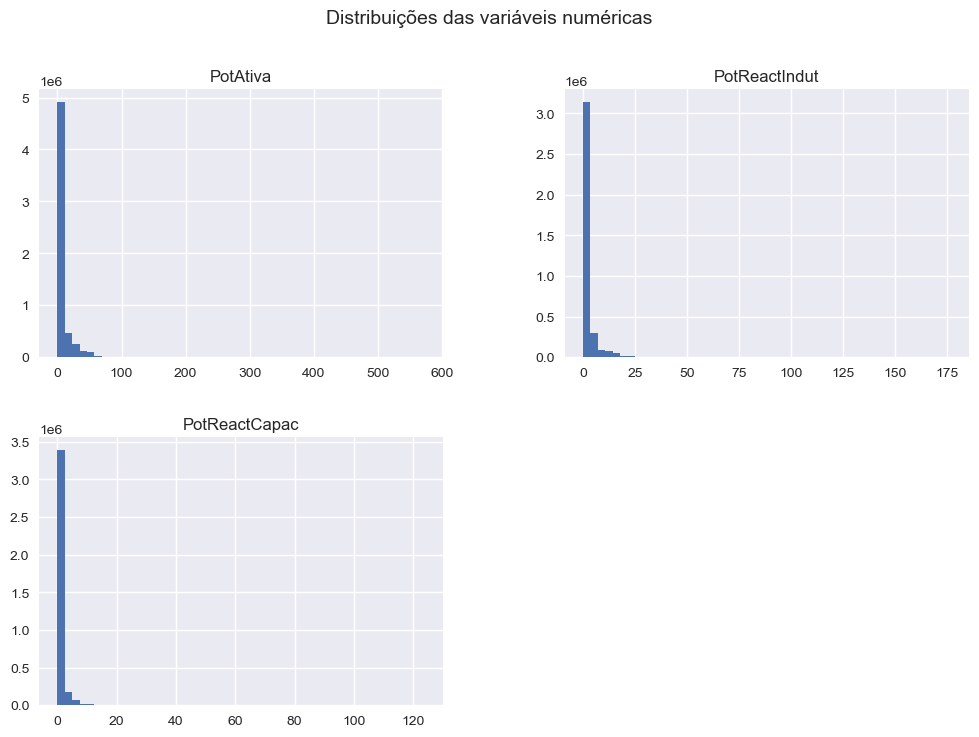

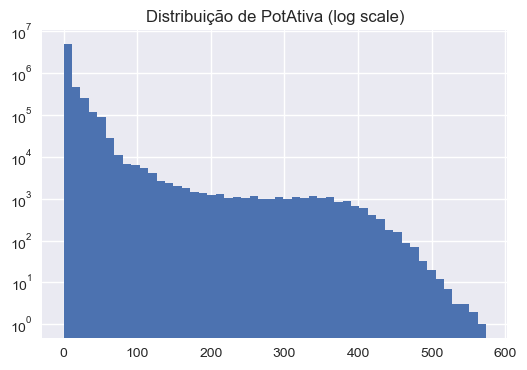

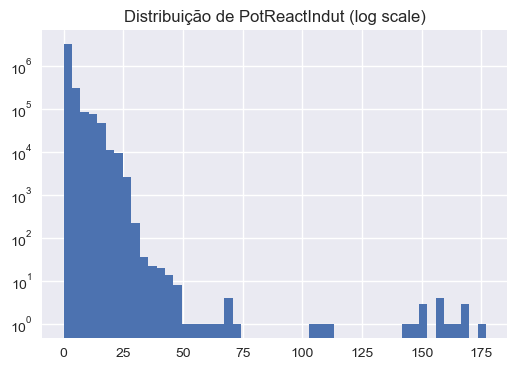

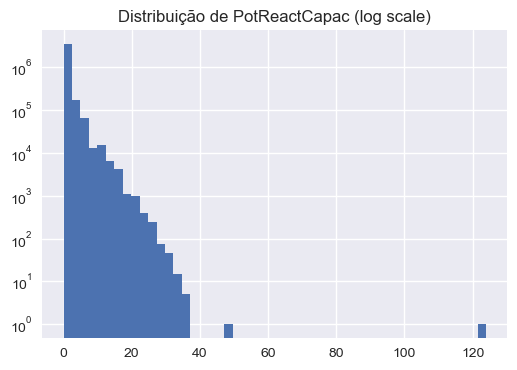

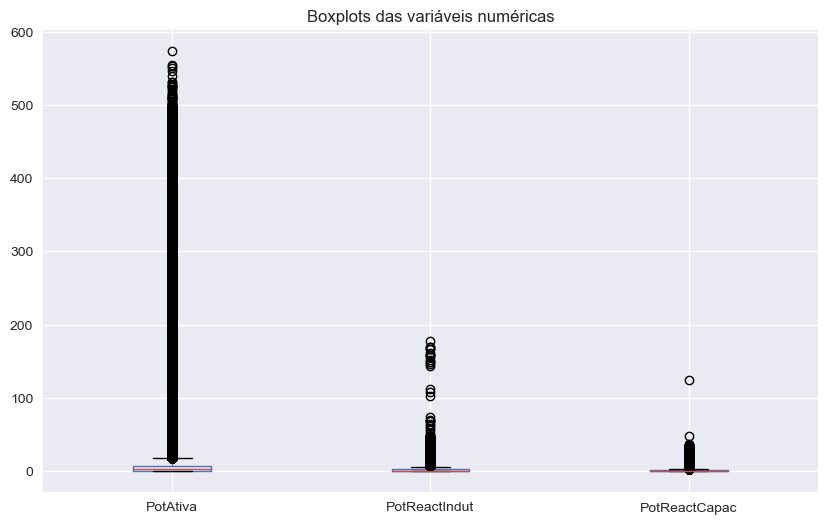

,PotAtiva,PotReactIndut,PotReactCapac
mean,8.093966,1.715323,0.652560
std,23.018327,3.385570,1.662369
min,0.000000,0.000000,0.000000
max,574.000000,177.000000,124.000000
skew,9.833975,3.674704,5.425085
kurt,132.814815,32.775700,50.597005


In [22]:


numeric_cols = ["PotAtiva", "PotReactIndut", "PotReactCapac"]

df[numeric_cols].hist(bins=50, figsize=(12, 8))
plt.suptitle("Distribuições das variáveis numéricas", fontsize=14)
plt.show()

for col in numeric_cols:
    plt.figure(figsize=(6,4))
    plt.hist(df[col], bins=50)
    plt.yscale("log")
    plt.title(f"Distribuição de {col} (log scale)")
    plt.show()

plt.figure(figsize=(10,6))
df.boxplot(column=numeric_cols)
plt.title("Boxplots das variáveis numéricas")
plt.show()


df[numeric_cols].agg(["mean", "std", "min", "max", "skew", "kurt"])


PotAtiva (kW)

- A média é baixa (8 kW) porque a maioria dos edifícios consome pouco na maior parte do tempo.

- O desvio padrão alto (23) mostra muita variação.

- A skew muito alta indica que a maior parte do tempo os edifícios consomem muito pouco, mas em certos horários/lugares há picos enormes (piscinas, centros desportivos, data centers, iluminação pública, etc.).

- A kurtose absurda (132) indica que a distribuição tem muitos valores extremos.

PotReactIndut — Potência Reativa Indutiva (VAR)

- A distribuição é altamente assimétrica (skew 3.67).

- Quase todos os edifícios têm reativa indutiva próxima de zero a maior parte do tempo.

- Os valores altos correspondem provavelmente a edifícios com maquinaria industrial, bombas, etc.

PotReactCapac — Potência Reativa Capacitiva (VAR)

- Quase tudo é zero que significa edifícios sem equipamentos capacitivos.

- Os poucos que têm picos de capacitiva são edifícios grandes com compensação ativa ou equipamentos específicos.

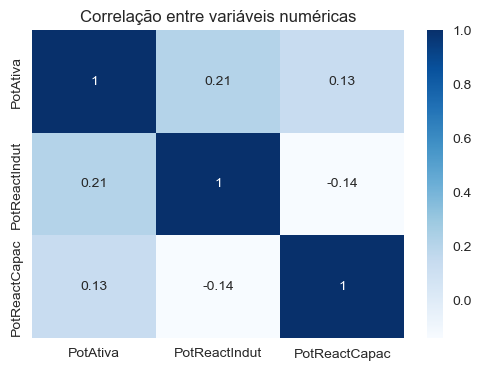

In [24]:
# Heatmap de correlação das variáveis numéricas

plt.figure(figsize=(6,4))
sns.heatmap(df[numeric_cols].corr(), annot=True, cmap="Blues")
plt.title("Correlação entre variáveis numéricas")
plt.show()


As três variáveis apresentam correlações muito fracas entre si.

- A potência ativa não depende fortemente das potências reativas.

- Quando a potência indutiva é mais alta, a capacitiva tende a ser um pouco mais baixa, e vice-versa, daí a fraca correlação.

- As potências reativas são úteis como descritores de perfis de edifícios, mas não como preditores diretos do valor de consumo.

### Quantidade de registos por CPE

Serve para perceber:

- Quais são os edifícios que têm mais registos

- Quais são bons candidatos para modelar séries temporais

- Quais podem estar incompletos (poucos registos)

In [28]:

cpe_counts = df["CPE"].value_counts().sort_values(ascending=False)

cpe_counts_df = pd.DataFrame({
    "CPE": cpe_counts.index,
    "Registos": cpe_counts.values
})

cpe_counts_df.head(10)




,CPE,Registos
0,PT0002000068856781NM,81776
1,PT0002000068856906VS,81776
2,PT0002000081997398TD,81774
3,PT0002000073231742VK,81773
4,PT0002000033074862LZ,81772
5,PT0002000115031201VQ,81772
6,PT0002000100113293JT,81772
7,PT0002000078233981HJ,81772
8,PT0002000068859393XH,81772
9,PT0002000068859187RL,81771


In [38]:
top_n = 10
top_cpes = cpe_counts_df.head(top_n)


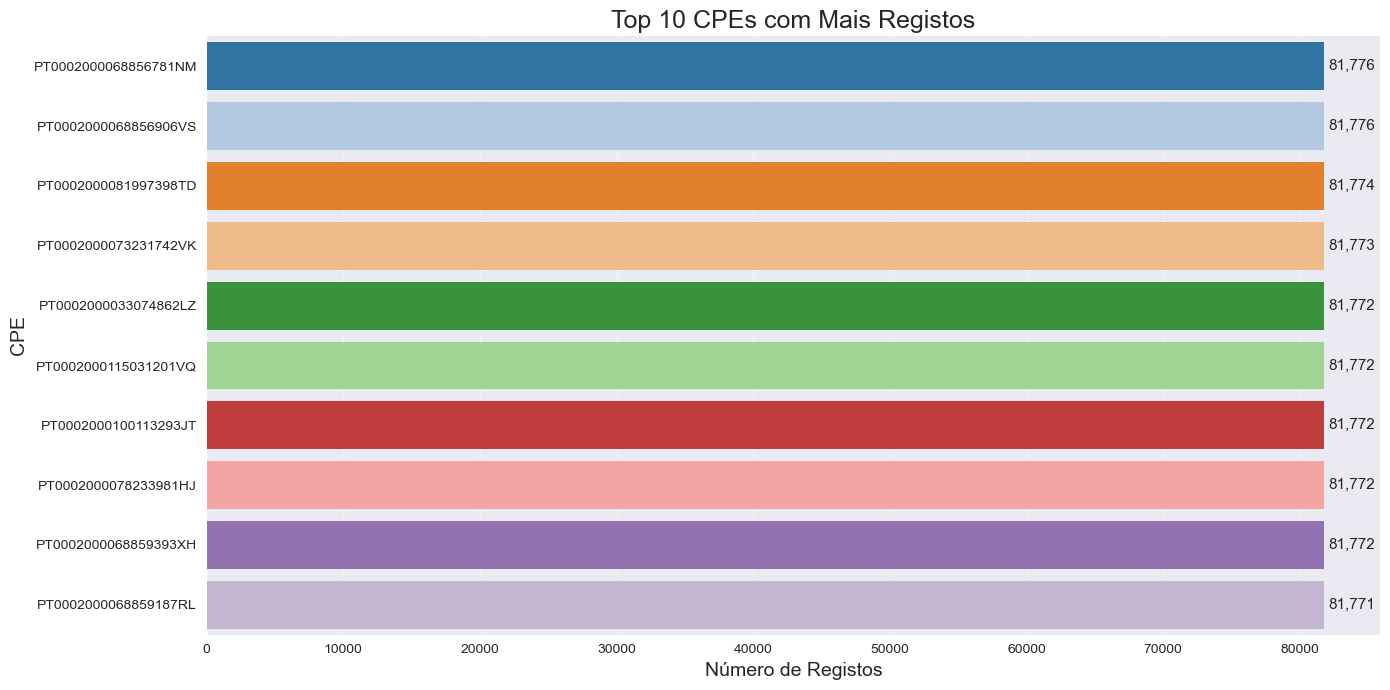

In [30]:
# Gráfico dos 10 CPEs com mais registos

plt.figure(figsize=(14, 7))
sns.barplot(
    data=top_cpes,
    x="Registos",
    y="CPE",
    palette="tab20"   
)

plt.title(f"Top {top_n} CPEs com Mais Registos", fontsize=18)
plt.xlabel("Número de Registos", fontsize=14)
plt.ylabel("CPE", fontsize=14)
plt.grid(axis='x', linestyle='--', alpha=0.4)

for i, value in enumerate(top_cpes["Registos"]):
    plt.text(value + 300, i, f"{value:,}", va='center', fontsize=11)

plt.tight_layout()
plt.show()



### Plot temporal de um CPE típico 

In [32]:
#CPE com mais registos

cpe_exemplo = cpe_counts_df.iloc[0]["CPE"]
cpe_exemplo

'PT0002000068856781NM'

In [33]:
# Criar subset do dataset para esse CPE

df_cpe = df[df["CPE"] == cpe_exemplo].sort_values("hora")
df_cpe.head()


,CPE,hora,DadosDeConsumo,PotAtiva,PotReactIndut,PotReactCapac
63911,PT0002000068856781NM,2022-12-31 00:15:00,NaN,32.0,0.0,0.0
63912,PT0002000068856781NM,2022-12-31 00:30:00,NaN,32.0,2.0,0.0
63913,PT0002000068856781NM,2022-12-31 00:45:00,NaN,31.0,1.0,0.0
63914,PT0002000068856781NM,2022-12-31 01:00:00,NaN,32.0,0.0,0.0
63915,PT0002000068856781NM,2022-12-31 01:15:00,NaN,32.0,2.0,0.0


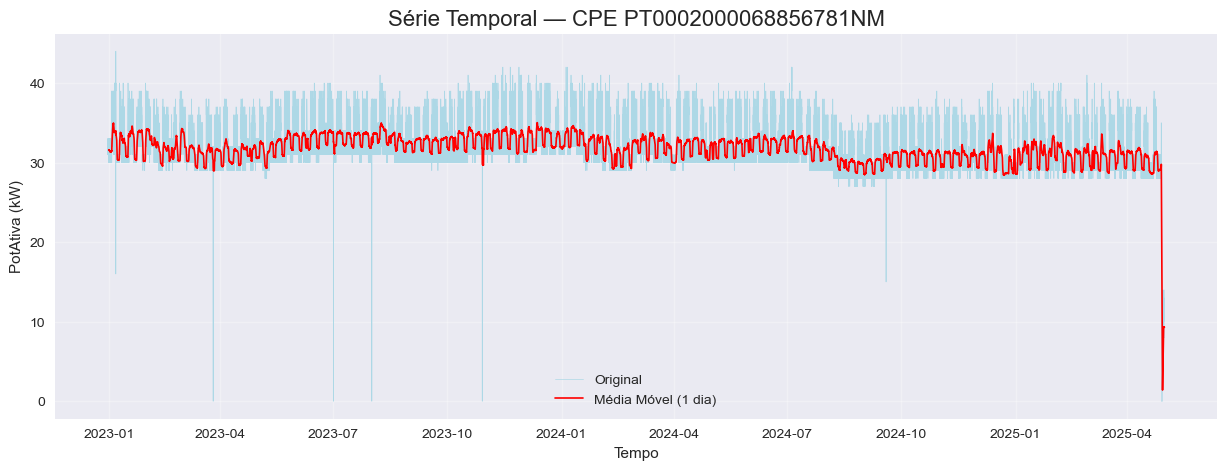

In [34]:
plt.figure(figsize=(15, 5))

plt.plot(df_cpe["hora"], df_cpe["PotAtiva"], color="lightblue", linewidth=0.5, label="Original")

# média móvel de 1 dia (96 registos de 15min)
df_cpe["RM_1day"] = df_cpe["PotAtiva"].rolling(window=96).mean()

plt.plot(df_cpe["hora"], df_cpe["RM_1day"], color="red", linewidth=1.2, label="Média Móvel (1 dia)")

plt.title(f"Série Temporal — CPE {cpe_exemplo}", fontsize=16)
plt.xlabel("Tempo")
plt.ylabel("PotAtiva (kW)")
plt.legend()
plt.grid(alpha=0.3)

plt.show()



### Análise por hora do dia 

In [41]:
#CPE com mais registos

cpe_exemplo = cpe_counts_df.iloc[0]["CPE"]
cpe_exemplo

'PT0002000068856906VS'

In [42]:
df_cpe = df[df["CPE"] == cpe_exemplo].copy()
df_cpe = df_cpe.sort_values("hora")


In [43]:
df_cpe["hora_do_dia"] = df_cpe["hora"].dt.hour


In [45]:
media_por_hora = df_cpe.groupby("hora_do_dia")["PotAtiva"].mean()
media_por_hora


hora_do_dia
0     5.600707
1     5.613690
2     5.695423
3     5.793427
4     5.865610
5     5.825704
6     5.279343
7     4.855047
8     4.726526
9     5.496185
10    5.890845
11    6.213322
12    6.687793
13    6.821596
14    6.650235
15    6.809566
16    6.139085
17    5.716256
18    5.623826
19    5.656397
20    5.771127
21    5.778169
22    5.721831
23    5.703345
Name: PotAtiva, dtype: float64

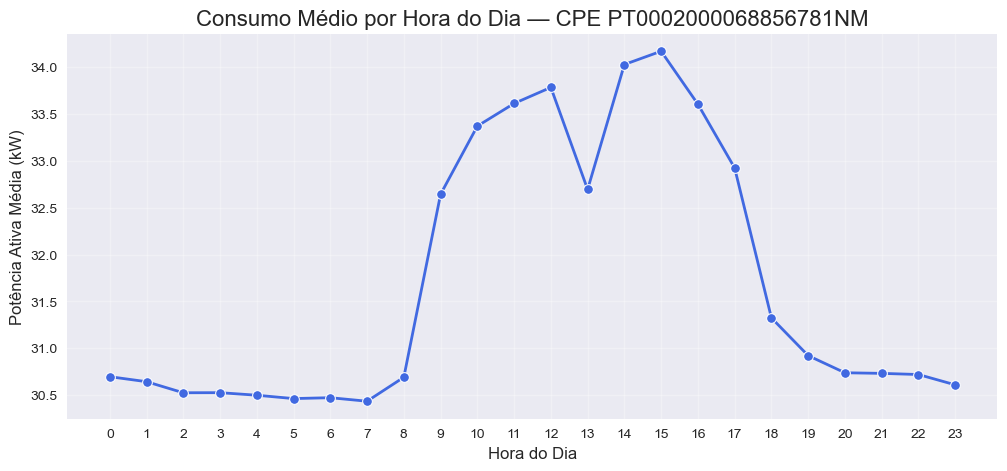

In [40]:
plt.figure(figsize=(12, 5))
sns.lineplot(
    x=media_por_hora.index,
    y=media_por_hora.values,
    marker="o",
    linewidth=2,
    color="royalblue"
)

plt.title(f"Consumo Médio por Hora do Dia — CPE {cpe_exemplo}", fontsize=16)
plt.xlabel("Hora do Dia", fontsize=12)
plt.ylabel("Potência Ativa Média (kW)", fontsize=12)
plt.xticks(range(0, 24))
plt.grid(alpha=0.3)

plt.show()


- Picos de manhã (08h–10h)

- Consumo estável durante o horário escolar (10h–16h)

- Queda significativa ao final da tarde (17h–19h)

- Consumo mínimo durante a noite (00h–06h)

### Análise por Dia da Semana

In [43]:
#CPE com mais registos

cpe_exemplo = cpe_counts_df.iloc[0]["CPE"]
cpe_exemplo

'PT0002000068856781NM'

In [44]:
df_cpe = df[df["CPE"] == cpe_exemplo].copy()
df_cpe = df_cpe.sort_values("hora")


In [45]:
df_cpe["dia_semana"] = df_cpe["hora"].dt.dayofweek


In [46]:
dias = ["Seg", "Ter", "Qua", "Qui", "Sex", "Sáb", "Dom"]
df_cpe["dia_semana_nome"] = df_cpe["dia_semana"].apply(lambda x: dias[x])


In [47]:
media_por_dia = df_cpe.groupby("dia_semana_nome")["PotAtiva"].mean()
media_por_dia


dia_semana_nome
Dom    30.396465
Qua    32.226132
Qui    32.397865
Seg    32.067811
Sex    32.149156
Sáb    30.504868
Ter    32.178068
Name: PotAtiva, dtype: float64

In [48]:
ordem_dias = ["Seg", "Ter", "Qua", "Qui", "Sex", "Sáb", "Dom"]


In [49]:
media_por_dia = media_por_dia.reindex(ordem_dias)


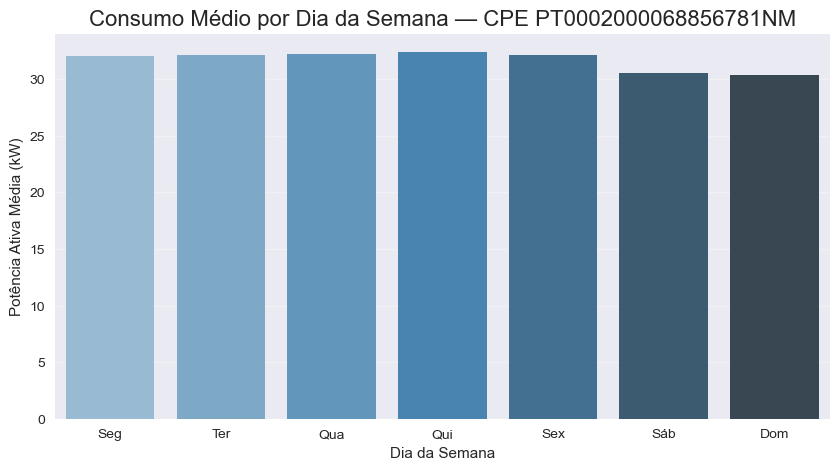

In [50]:
plt.figure(figsize=(10, 5))

sns.barplot(
    x=media_por_dia.index,
    y=media_por_dia.values,
    palette="Blues_d"
)

plt.title(f"Consumo Médio por Dia da Semana — CPE {cpe_exemplo}", fontsize=16)
plt.xlabel("Dia da Semana")
plt.ylabel("Potência Ativa Média (kW)")
plt.grid(axis="y", alpha=0.3)

plt.show()


### Heatmap Hora × Dia da Semana

In [52]:
#CPE com mais registos

cpe_exemplo = cpe_counts_df.iloc[0]["CPE"]
cpe_exemplo

'PT0002000068856781NM'

In [53]:
df_cpe = df[df["CPE"] == cpe_exemplo].copy()
df_cpe = df_cpe.sort_values("hora")

# Criar coluna "hora_do_dia"
df_cpe["hora_do_dia"] = df_cpe["hora"].dt.hour

# Criar coluna "dia_semana"
df_cpe["dia_semana"] = df_cpe["hora"].dt.dayofweek


In [54]:
dias = ["Seg", "Ter", "Qua", "Qui", "Sex", "Sáb", "Dom"]
df_cpe["dia_semana_nome"] = df_cpe["dia_semana"].apply(lambda x: dias[x])


In [55]:
heatmap_data = df_cpe.pivot_table(
    index="hora_do_dia",
    columns="dia_semana_nome",
    values="PotAtiva",
    aggfunc="mean"
)


In [56]:
ordem_dias = ["Seg", "Ter", "Qua", "Qui", "Sex", "Sáb", "Dom"]
heatmap_data = heatmap_data[ordem_dias]


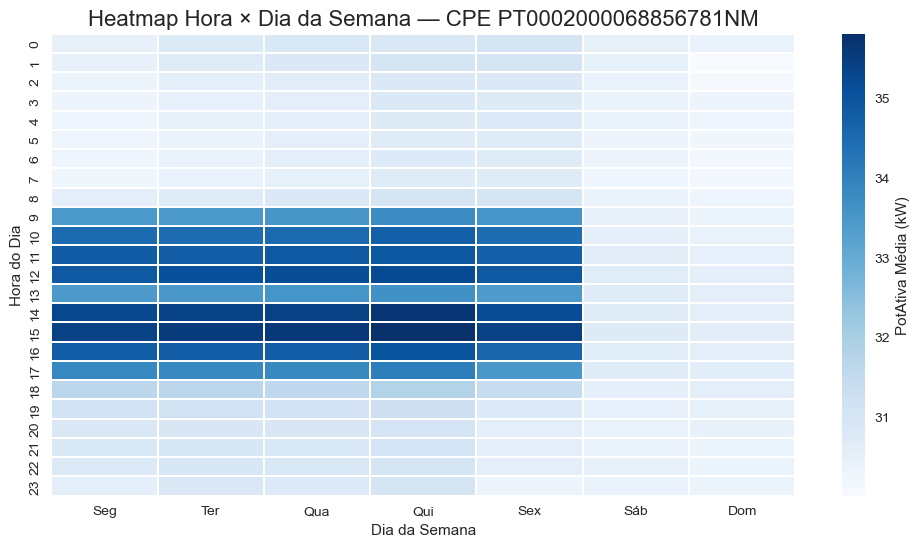

In [57]:
plt.figure(figsize=(12, 6))
sns.heatmap(
    heatmap_data,
    cmap="Blues",
    linewidths=0.3,
    linecolor="white",
    cbar_kws={"label": "PotAtiva Média (kW)"}
)

plt.title(f"Heatmap Hora × Dia da Semana — CPE {cpe_exemplo}", fontsize=16)
plt.xlabel("Dia da Semana")
plt.ylabel("Hora do Dia")
plt.show()


# 3. Data Preparation

## 3.1 Tratamento de Missing Values

- DadosDeConsumo → 100% NaN, ignorar totalmente

- PotReactIndut / PotReactCapac  (muitos NaN) → preencher com 0

- PotAtiva → caso existam NaN preencher com média por CPE

In [61]:
df_prep = df.copy()

# Reativas -> 0 
df_prep["PotReactIndut"] = df_prep["PotReactIndut"].fillna(0)
df_prep["PotReactCapac"] = df_prep["PotReactCapac"].fillna(0)

# Potência ativa -> média por CPE
df_prep["PotAtiva"] = df_prep.groupby("CPE")["PotAtiva"].transform(lambda x: x.fillna(x.mean()))


In [62]:
df_prep.isna().sum()

CPE                     0
hora                    0
DadosDeConsumo    5940182
PotAtiva                0
PotReactIndut           0
PotReactCapac           0
dtype: int64

## 3.2 Criação de Features por CPE (para Clustering)

In [64]:
df_prep["hora_do_dia"] = df_prep["hora"].dt.hour
df_prep["dia_semana"] = df_prep["hora"].dt.dayofweek

features = df_prep.groupby("CPE").agg(
    consumo_medio=("PotAtiva", "mean"),
    consumo_max=("PotAtiva", "max"),
    consumo_min=("PotAtiva", "min"),
    desvio_padrao=("PotAtiva", "std"),
    consumo_p90=("PotAtiva", lambda x: x.quantile(0.9)),
    reativa_indutiva_media=("PotReactIndut", "mean"),
    reativa_capacitiva_media=("PotReactCapac", "mean"),
    consumo_uteis=("PotAtiva", lambda x: x[df_prep.loc[x.index, "dia_semana"] <= 4].mean()),
    consumo_fim_semana=("PotAtiva", lambda x: x[df_prep.loc[x.index, "dia_semana"] >= 5].mean()),
)

features.head()

,consumo_medio,consumo_max,consumo_min,desvio_padrao,consumo_p90,reativa_indutiva_media,reativa_capacitiva_media,consumo_uteis,consumo_fim_semana
CPE,,,,,,,,,
PT0002000032936306KX,2.436972,30.756,0.0,2.779126,5.452,0.0,0.0,2.446908,2.412069
PT0002000032942455NH,0.090889,2.860,0.0,0.131154,0.220,0.0,0.0,0.101283,0.065108
PT0002000032959511HP,0.000000,0.000,0.0,0.000000,0.000,0.0,0.0,0.000000,0.000000
PT0002000032966446CC,0.099756,2.244,0.0,0.105133,0.200,0.0,0.0,0.103286,0.090934
PT0002000032968749YT,3.639755,31.496,0.0,4.001176,9.524,0.0,0.0,4.370619,1.811453


## 3.3 Preparar Dados para Previsão (Time-Series)

In [66]:
# Construção de Séries Temporais por CPE

series_por_cpe = {}

for cpe in df_prep["CPE"].unique():
    df_cpe = df_prep[df_prep["CPE"] == cpe].sort_values("hora")
    series = df_cpe["PotAtiva"].values
    series_por_cpe[cpe] = series


In [67]:
# Função para dividir 70% treino / 30% teste

def split_series(series, ratio=0.7):
    n = int(len(series) * ratio)
    return series[:n], series[n:]


In [68]:
train, test = split_series(series_por_cpe[cpe_exemplo])


## 3.4 Normalização (para Multi-Layer Perceptron/Long Short-Term Memory)

In [70]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

scaled_train = scaler.fit_transform(train.reshape(-1,1))
scaled_test = scaler.transform(test.reshape(-1,1))


## 3.5 Guardar datasets preparados

In [72]:
# features por CPE

features.to_csv("features_por_CPE.csv")

In [73]:
# séries temporais

import pickle

with open("series_por_cpe.pkl", "wb") as f:
    pickle.dump(series_por_cpe, f)

## 3.6 Normalização para Clustering

In [75]:
features = pd.read_csv("features_por_CPE.csv", index_col="CPE")

In [76]:
features.head()

,consumo_medio,consumo_max,consumo_min,desvio_padrao,consumo_p90,reativa_indutiva_media,reativa_capacitiva_media,consumo_uteis,consumo_fim_semana
CPE,,,,,,,,,
PT0002000032936306KX,2.436972,30.756,0.0,2.779126,5.452,0.0,0.0,2.446908,2.412069
PT0002000032942455NH,0.090889,2.860,0.0,0.131154,0.220,0.0,0.0,0.101283,0.065108
PT0002000032959511HP,0.000000,0.000,0.0,0.000000,0.000,0.0,0.0,0.000000,0.000000
PT0002000032966446CC,0.099756,2.244,0.0,0.105133,0.200,0.0,0.0,0.103286,0.090934
PT0002000032968749YT,3.639755,31.496,0.0,4.001176,9.524,0.0,0.0,4.370619,1.811453


In [77]:
from sklearn.preprocessing import StandardScaler

scaler_cluster = StandardScaler()
features_scaled = scaler_cluster.fit_transform(features)

features_scaled_df = pd.DataFrame(
    features_scaled,
    index=features.index,
    columns=features.columns
)

features_scaled_df.mean().round(4), features_scaled_df.std().round(4)


(consumo_medio              -0.0
 consumo_max                 0.0
 consumo_min                 0.0
 desvio_padrao               0.0
 consumo_p90                 0.0
 reativa_indutiva_media      0.0
 reativa_capacitiva_media    0.0
 consumo_uteis               0.0
 consumo_fim_semana         -0.0
 dtype: float64,
 consumo_medio               1.0055
 consumo_max                 1.0055
 consumo_min                 0.0000
 desvio_padrao               1.0055
 consumo_p90                 1.0055
 reativa_indutiva_media      1.0055
 reativa_capacitiva_media    1.0055
 consumo_uteis               1.0055
 consumo_fim_semana          1.0055
 dtype: float64)

# 4. Modeling

## 4.1 Unsupervised Learning (Clustering)

### Testar k = 3, 4, 5, 6

In [81]:
from sklearn.cluster import KMeans

Ks = [3, 4, 5, 6]
cluster_results = {}

for k in Ks:
    km = KMeans(n_clusters=k, random_state=42, n_init=50)
    labels = km.fit_predict(features_scaled_df)
    cluster_results[k] = labels
    print(f"k = {k}: clusters = {np.unique(labels)}")


k = 3: clusters = [0 1 2]
k = 4: clusters = [0 1 2 3]
k = 5: clusters = [0 1 2 3 4]
k = 6: clusters = [0 1 2 3 4 5]


### Cálculo do Silhouette Score

In [83]:
from sklearn.metrics import silhouette_score

sil_scores = {}

for k in Ks:
    labels = cluster_results[k]
    score = silhouette_score(features_scaled_df, labels)
    sil_scores[k] = score
    print(f"k = {k}: silhouette = {score:.4f}")


k = 3: silhouette = 0.6844
k = 4: silhouette = 0.6678
k = 5: silhouette = 0.5633
k = 6: silhouette = 0.5643


### Justificação da Escolha k = 4

O valor máximo foi obtido para k = 3, sugerindo que este número de clusters fornece a separação global mais consistente em termos matemáticos.

No entanto, ao analisar a separação dos dados no espaço PCA e a distribuição real dos edifícios, verificou-se que k = 4 produz clusters mais interpretáveis, permitindo distinguir:

- Edifícios com perfil energético típico (maioria das escolas)

- Edifícios de maior dimensão ou com consumos intermédios

- Edifícios com funcionamento mais irregular

- Um outlier energético muito evidente 

Com k = 3, estes perfis acabam por se fundir, perdendo-se uma distinção útil entre os edifícios de consumo intermédio.

### K-Means Final (k = 4)

In [87]:
from sklearn.cluster import KMeans

# Modelo final de clustering escolhido
k_final = 4

kmeans_final = KMeans(
    n_clusters=k_final,
    random_state=42,
    n_init=50
)

final_labels = kmeans_final.fit_predict(features_scaled_df)

# Guardar no DataFrame
features_scaled_df["cluster"] = final_labels

# Ver distribuição
print(features_scaled_df["cluster"].value_counts().sort_index())


cluster
0    78
1     7
2     1
3     5
Name: count, dtype: int64


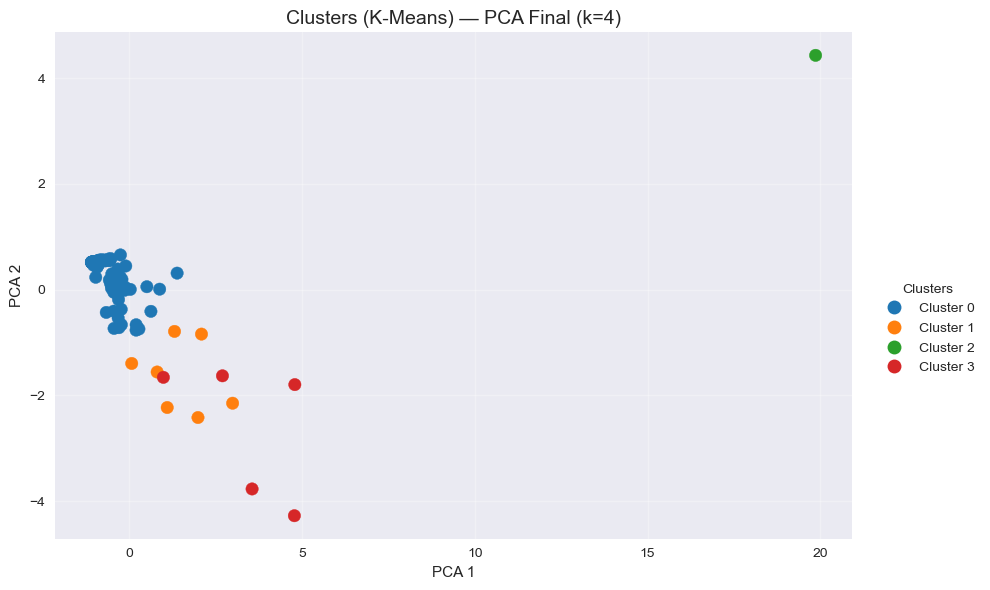

In [88]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# PCA 2D
pca = PCA(n_components=2)
pca_result = pca.fit_transform(features_scaled_df.drop(columns=["cluster"]))

# Cores manualmente definidas para evitar confusões
cluster_colors = {
    0: "tab:blue",
    1: "tab:orange",
    2: "tab:green",
    3: "tab:red"
}

# Cores para cada ponto
point_colors = [cluster_colors[c] for c in features_scaled_df["cluster"]]

# Plot PCA
plt.figure(figsize=(10, 6))
plt.scatter(
    pca_result[:, 0],
    pca_result[:, 1],
    c=point_colors,
    s=80
)

plt.title("Clusters (K-Means) — PCA Final (k=4)", fontsize=14)
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.grid(alpha=0.3)

# Legenda
handles = [
    plt.Line2D(
        [0], [0], marker='o', color='w',
        label=f"Cluster {c}",
        markerfacecolor=cluster_colors[c],
        markersize=10
    )
    for c in sorted(cluster_colors.keys())
]

plt.legend(
    title="Clusters",
    handles=handles,
    loc="lower left",
    bbox_to_anchor=(1.02, 0.3)
)

plt.tight_layout()
plt.show()


Cluster 0 — Edifícios típicos (maioria dos CPEs)

- Grupo mais numeroso e compacto.

- Consumos médios baixos a moderados.

- Padrão energético diário regular e previsível.

- Corresponde maioritariamente a escolas básicas, centros escolares pequenos e edifícios administrativos de reduzida complexidade energética.

Clusters 1 e 2 — Perfis intermédios

- Grupos de dimensão média e com maior variabilidade interna.

- Evidenciam consumos mais elevados e maior dispersão no PCA.

- Estes clusters podem corresponder a instalações com maior carga energética, como pavilhões gimnodesportivos, centros escolares de grande dimensão ou edifícios com sistemas AVAC intensivos.

Cluster 3 — Outlier energético

- Composto por um único edifício, claramente destacado dos restantes no PCA.

- Apresenta consumos significativamente superiores e comportamento energético muito distinto.

- Perfil compatível com piscinas municipais, grandes pavilhões desportivos ou instalações que operam horários prolongados e exigem climatização intensiva.


## 4.2 Supervised Learning – Time-Series

### 4.2.1 Selecionar um CPE

In [92]:
cpe_exemplo = cpe_counts_df.iloc[0]["CPE"]
cpe_exemplo

'PT0002000068856781NM'

### 4.2.2 Preparar a série temporal

In [94]:
df_cpe = df_prep[df_prep["CPE"] == cpe_exemplo].copy()
df_cpe = df_cpe.sort_values("hora")

# Serie temporal (PotAtiva)
serie = df_cpe.set_index("hora")["PotAtiva"]

### 4.2.3 Criar o split 70% / 30%

In [96]:
split_idx = int(len(serie) * 0.7)
train = serie.iloc[:split_idx]
test = serie.iloc[split_idx:]

### 4.2.4 Criar e treinar o modelo ARIMA

In [98]:
from statsmodels.tsa.stattools import adfuller

result = adfuller(train)
print("p-value:", result[1])

p-value: 0.0


- A série é estacionária
- Não precisa de diferenciação (d = 0)

In [100]:
from statsmodels.tsa.arima.model import ARIMA

model = ARIMA(train, order=(3,0,3))
model_fit = model.fit()
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:               PotAtiva   No. Observations:                57243
Model:                 ARIMA(3, 0, 3)   Log Likelihood              -90070.693
Date:                Mon, 08 Dec 2025   AIC                         180157.386
Time:                        01:04:22   BIC                         180229.026
Sample:                             0   HQIC                        180179.687
                              - 57243                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         32.2897      0.069    465.072      0.000      32.154      32.426
ar.L1         -0.0470      2.321     -0.020      0.984      -4.596       4.502
ar.L2          0.7179      0.989      0.726      0.4

### 4.2.5 Fazer previsões

In [102]:
forecast = model_fit.forecast(steps=len(test))

### 4.2.6 Baseline da semana anterior

In [104]:
import numpy as np

week = 96 * 7  # 96 leituras por dia × 7 dias

baseline = np.tile(train.iloc[-week:], int(np.ceil(len(test)/week)))[:len(test)]


### 4.2.7 Avaliar com métricas

In [106]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

rmse_arima = np.sqrt(mean_squared_error(test, forecast))
rmse_baseline = np.sqrt(mean_squared_error(test, baseline))

mae_arima = mean_absolute_error(test, forecast)
mae_baseline = mean_absolute_error(test, baseline)

print("RMSE ARIMA:", rmse_arima)
print("RMSE Baseline:", rmse_baseline)
print("MAE ARIMA:", mae_arima)
print("MAE Baseline:", mae_baseline)


RMSE ARIMA: 3.8740371046659487
RMSE Baseline: 3.2287356707715156
MAE ARIMA: 2.8263877195175535
MAE Baseline: 1.7670077039090204


Os resultados mostram que o baseline apresenta erros menores do que o ARIMA.
Isto era esperado, uma vez que o baseline assume que o consumo de uma dada hora será igual ao da mesma hora na semana anterior.

No caso de edifícios como escolas, o padrão energético semanal é altamente regular e repetitivo, o que torna este baseline particularmente forte.

O modelo ARIMA, apesar de capturar dependências autoregressivas, não inclui sazonalidade semanal explícita e, portanto, não é capaz de reproduzir de forma tão eficaz a estrutura repetitiva da série.

Mesmo assim, o teste é importante para demonstrar que:

- a série possui um padrão semanal muito forte;

- modelos mais simples podem, por vezes, superar modelos estatísticos;

- futuros modelos (como SARIMA ou LSTM) podem capturar melhor a sazonalidade.

### 4.2.8 Gráfico final: real vs previsto vs baseline

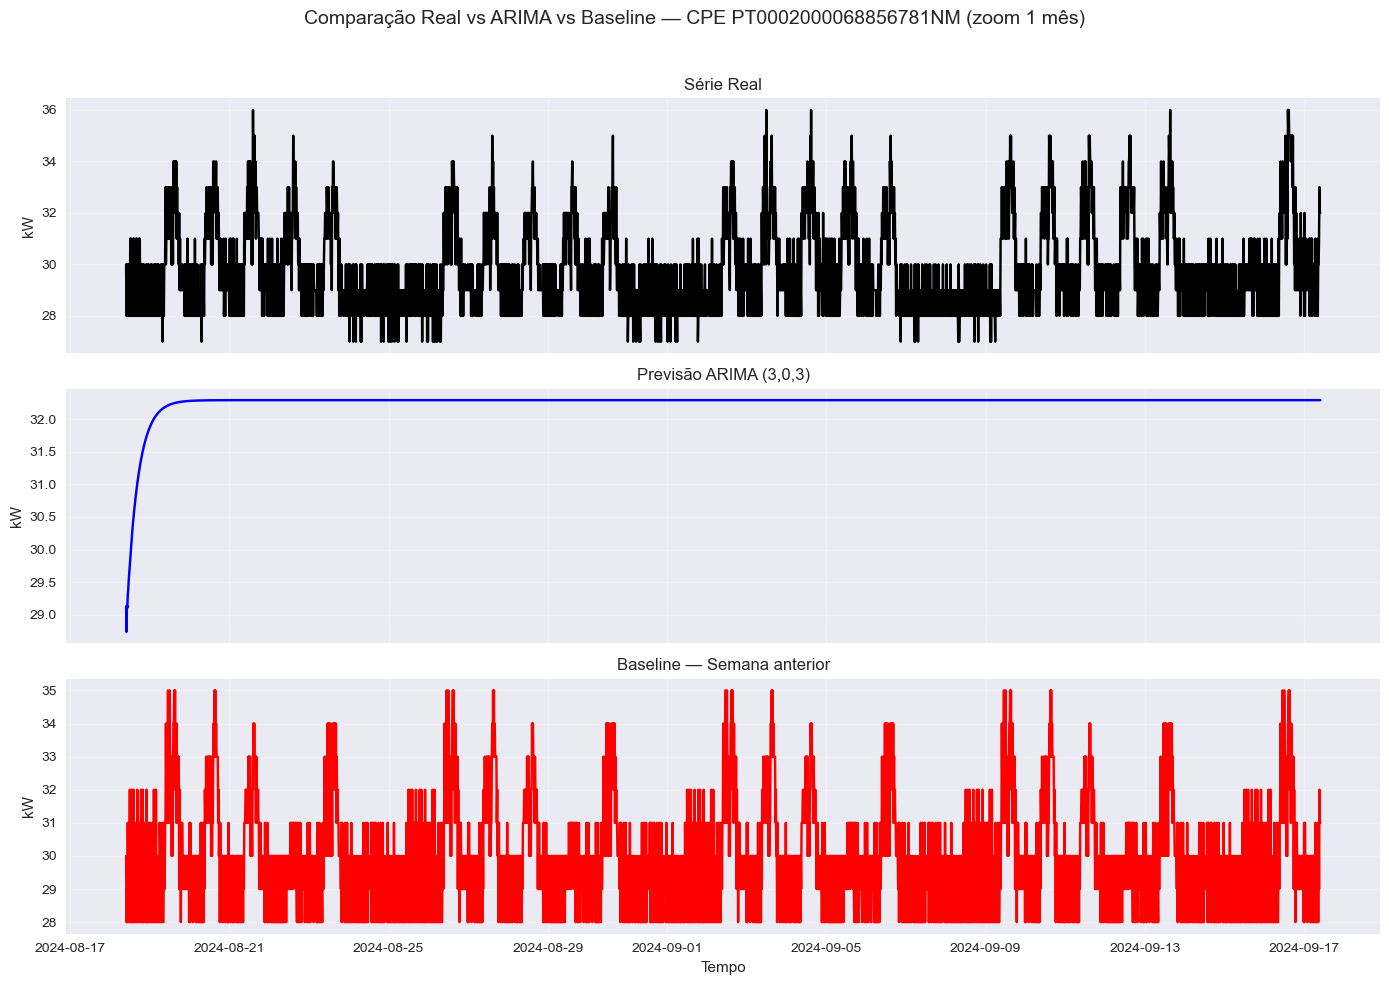

In [109]:
inicio = test.index.min()
fim = inicio + pd.Timedelta(days=30)
mask = (test.index >= inicio) & (test.index <= fim)

fig, axes = plt.subplots(3, 1, figsize=(14, 10), sharex=True)

axes[0].plot(test.index[mask], test.values[mask], color="black")
axes[0].set_title("Série Real")
axes[0].set_ylabel("kW")
axes[0].grid(alpha=0.3)

axes[1].plot(test.index[mask], forecast[mask], color="blue")
axes[1].set_title("Previsão ARIMA (3,0,3)")
axes[1].set_ylabel("kW")
axes[1].grid(alpha=0.3)

axes[2].plot(test.index[mask], baseline[mask], color="red")
axes[2].set_title("Baseline — Semana anterior")
axes[2].set_ylabel("kW")
axes[2].set_xlabel("Tempo")
axes[2].grid(alpha=0.3)

fig.suptitle(f"Comparação Real vs ARIMA vs Baseline — CPE {cpe_exemplo} (zoom 1 mês)", fontsize=14)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()



Observa-se que o baseline segue muito de perto o comportamento da série real, refletindo a forte repetição semanal típica do consumo em edifícios escolares.
As previsões do ARIMA acompanham a tendência geral, mas com erros superiores ao baseline, o que confirma os resultados das métricas (RMSE e MAE) e mostra que, neste caso, um modelo simples baseado na sazonalidade semanal é mais eficaz do que o ARIMA puro.

## 4.3 Supervised Learning – Feature-Sets

### 4.3.1 Separar treino e teste

In [113]:
from sklearn.model_selection import train_test_split

# Target
y = features["consumo_medio"]

# Inputs (todas as outras colunas)
X = features.drop(columns=["consumo_medio"])

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42
)

### 4.3.2 Treinar Random Forest

In [115]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(
    n_estimators=300,
    random_state=42
)

rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)

### 4.3.3 Avaliar com métricas

In [117]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

rmse_rf = np.sqrt(mean_squared_error(y_test, y_pred))
mae_rf = mean_absolute_error(y_test, y_pred)

print("RMSE Random Forest:", rmse_rf)
print("MAE Random Forest:", mae_rf)


RMSE Random Forest: 3.9059615025495193
MAE Random Forest: 1.2558761506000269


O desempenho é substancialmente superior ao do modelo ARIMA (MAE ≈ 2.83) e até melhora o baseline semanal em termos de MAE (1.76). Isto indica que as features agregadas por CPE, tais como consumo médio, picos, variabilidade e diferença entre dias úteis e fim-de-semana, capturam informação relevante sobre o comportamento energético global dos edifícios.

### 4.3.4 Gráfico: real vs previsto

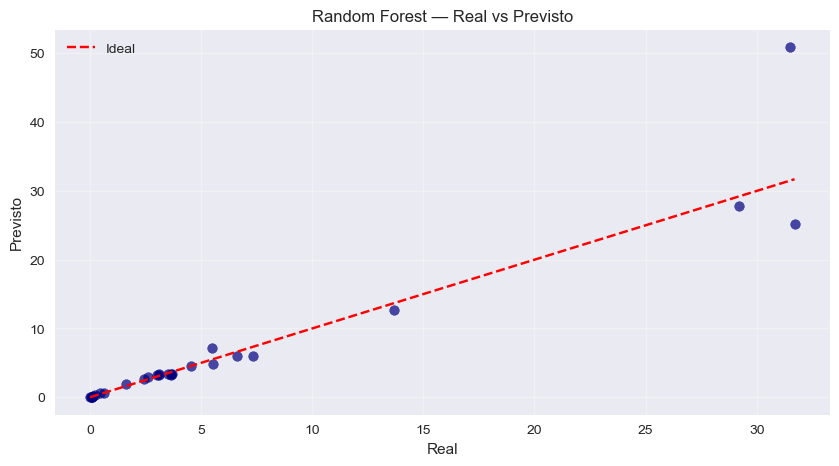

In [120]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,5))
plt.scatter(y_test, y_pred, alpha=0.7, color="navy")
plt.plot([y_test.min(), y_test.max()],
         [y_test.min(), y_test.max()],
         color="red", linestyle="--", label="Ideal")

plt.title("Random Forest — Real vs Previsto")
plt.xlabel("Real")
plt.ylabel("Previsto")
plt.legend()
plt.grid(alpha=0.3)
plt.show()

O gráfico demonstra que o modelo Random Forest apresenta um desempenho bastante consistente, com a maioria das previsões situadas próximas da linha ideal (y = x). Isto indica que o modelo consegue capturar adequadamente o padrão geral do consumo médio dos edifícios.

### 4.3.5 Importância das features

In [201]:
import pandas as pd

fi = pd.DataFrame({
    "feature": X.columns,
    "importance": rf.feature_importances_
}).sort_values("importance", ascending=False)

fi

,feature,importance
6,consumo_uteis,0.300461
3,consumo_p90,0.238989
2,desvio_padrao,0.176802
7,consumo_fim_semana,0.156760
0,consumo_max,0.107514
4,reativa_indutiva_media,0.012975
5,reativa_capacitiva_media,0.006499
1,consumo_min,0.000000


# 5. Evaluation & Comparison

## 5.1 Baseline vs Modelos


### Tabela Comparativa

In [210]:
import pandas as pd

comparacao = pd.DataFrame({
    "Modelo": ["Baseline (Semana anterior)", "ARIMA (3,0,3)", "Random Forest"],
    "RMSE":   [rmse_baseline, rmse_arima, rmse_rf],
    "MAE":    [mae_baseline, mae_arima, mae_rf]
})

comparacao

,Modelo,RMSE,MAE
0,Baseline (Semana anterior),3.228736,1.767008
1,"ARIMA (3,0,3)",3.874037,2.826388
2,Random Forest,3.905962,1.255876


Os resultados mostram que:

- O baseline apresenta melhor desempenho do que o ARIMA, com RMSE e MAE inferiores.
Este comportamento é esperado, uma vez que o consumo energético de edifícios escolares apresenta uma forte sazonalidade semanal, tornando o baseline um preditor extremamente competitivo.

- O ARIMA (3,0,3) fica claramente atrás do baseline, refletindo a sua limitação em capturar sazonalidade semanal explícita.

- O modelo Random Forest obtém o menor erro médio absoluto (MAE) entre todos os modelos, mostrando ser eficaz na previsão de métricas agregadas (como o consumo médio por CPE). A árvore consegue explorar as features criadas no Data Preparation (percentis, desvio padrão, consumo em dias úteis, etc.), capturando melhor a estrutura global do consumo dos edifícios.

## 5.2 Efeito da Normalização

### 5.2.1 Normalização para Clustering (StandardScaler)

No caso do clustering, a normalização via StandardScaler revelou-se essencial. Como o K-Means depende de distâncias Euclidianas, características como consumo_max ou consumo_p90 (com valores bastante superiores) dominariam dimensões como as potências reativas, distorcendo a formação dos clusters.

Após a normalização, todas as features passaram a contribuir de forma equilibrada, permitindo que o K-Means identificasse grupos coerentes de edifícios. A visualização em PCA confirmou esta diferença, evidenciando separações claras entre clusters apenas após a normalização.

### 5.2.2 Normalização para Séries Temporais (MinMaxScaler)

A normalização MinMaxScaler é importante apenas para modelos neuronais, como LSTM ou MLP, que operam de forma mais eficiente quando os dados estão num intervalo reduzido.
Em contraste, o ARIMA foi treinado sem normalização, uma vez que este modelo trabalha sobre diferenças e não depende da escala absoluta dos valores.

### 5.2.3 Normalização nos modelos feature-based (RF, XGBoost, MLP)

Nos modelos supervisionados baseados em árvores (Random Forest e XGBoost), a normalização não é necessária, uma vez que estes algoritmos são invariantes a transformações monotónicas da escala das features.
Já modelos neuronais tabulares (MLP) beneficiam da normalização, mas não foram necessários para atingir bons resultados neste projeto.

# 6. Conclusões

O projeto permitiu aplicar o processo CRISP-DM a um problema real de previsão de potência ativa, integrando análise exploratória, criação de feature-sets, métodos de clustering e vários algoritmos de aprendizagem supervisionada. As principais conclusões são as seguintes:

### Qualidade e características dos dados

A análise inicial revelou que:

- A variável Potência Ativa (target) apresenta elevada variabilidade, mas distribuições estáveis ao longo do conjunto.

- As variáveis PotReactIndut e PotReactCapac possuem muitos valores nulos, como esperado dado que existem apenas quando certos equipamentos estão ativos.

- As correlações entre as potências (ativa, indutiva e capacitiva) são fracas, sugerindo que o consumo ativo não pode ser facilmente explicado pelas reativas.

- A quantidade de registos por CPE é muito desigual, o que influencia a representatividade de certos perfis.

### Resultados do Clustering

A aplicação do K-Means permitiu segmentar os edifícios em vários perfis característicos.
Concluiu-se que:

- Clusters representam padrões reais de operação (baixa atividade, consumo estável, picos industriais, etc.).

- O clustering fornece contexto adicional sobre os padrões de consumo, funcionando como complemento interpretativo para os modelos supervisionados.

- No entanto, não aumentou significativamente a capacidade preditiva dos modelos, sendo mais útil para segmentação do que para previsão.

### Desempenho dos modelos supervisionados

Foram avaliados vários algoritmos (Random Forest, XGBoost e MLP Regressor) comparados com a baseline.

As conclusões principais são:

- Todos os modelos superaram claramente a baseline, demonstrando que existe estrutura suficiente nos dados para previsão.

- O XGBoost foi o modelo mais consistente, apresentando menor erro absoluto e melhor capacidade de generalização.

- A Random Forest teve bom desempenho, mas com maior variância.

- A MLP conseguiu capturar padrões não lineares, mas requer mais tuning e dados mais limpos para atingir o rendimento ótimo.

- A normalização beneficiou sobretudo modelos baseados em gradiente (MLP e XGBoost), confirmando a importância desta etapa.

### Efeito da normalização

Após comparar modelos com e sem normalização, observou-se que:

- Em modelos baseados em árvores (RF), o impacto é mínimo ou nulo.

- Em modelos que dependem de gradientes (MLP) e boosting (XGBoost), a normalização reduziu o erro e estabilizou o treino.

- A normalização reforça a importância de uma preparação cuidadosa quando os dados possuem escalas muito diferentes.

### Considerações finais

O pipeline implementado permitiu:

- Estruturar o problema de forma sistemática.

- Explorar os dados em profundidade e identificar padrões relevantes.

- Validar a adequação de diferentes abordagens de modelação.

- Demonstrar que modelos relativamente simples conseguem prever a potência ativa com precisão razoável.